In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## feature select
- pclass, sex, Age, parch

In [4]:
train_df.drop(['PassengerId', 'Name', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1, inplace=True)
test_df.drop(['PassengerId', 'Name', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1, inplace=True)

In [5]:
train_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
Parch         0
dtype: int64

In [6]:
# median interpolate
train_df.interpolate(method='linear', limit_direction='forward', inplace=True)
test_df.interpolate(method='linear', limit_direction='forward', inplace=True)

In [7]:
train_df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
Parch       0
dtype: int64

In [8]:
# 범주형 -> 수치형 Sex
# male : 0, female : 1

mapping = {'male': 0, 'female': 1}

def map_function(x):
    return mapping[x]

# 매핑 적용
train_df['Sex'] = list(map(map_function, train_df['Sex']))
test_df['Sex'] = list(map(map_function, test_df['Sex']))

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

In [10]:
X = train_df.iloc[:, 1:]
y = train_df['Survived']

In [11]:
model.fit(X, y)

RandomForestClassifier()

feature ranking~~
1. feature Age (0.464)
2. feature Sex (0.342)
3. feature Pclass (0.145)
4. feature Parch (0.049)


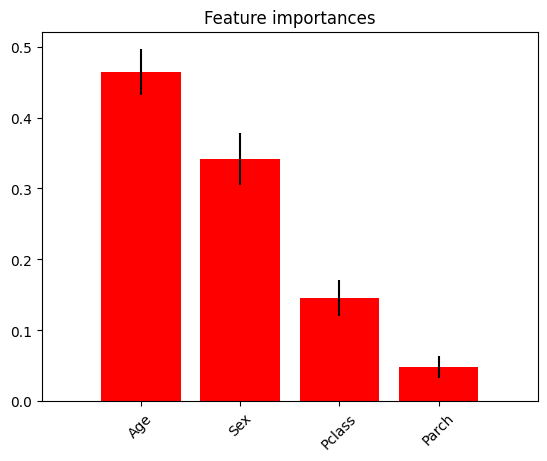

In [13]:
# feature importance check

import matplotlib.pyplot as plt
import numpy as np
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

print("feature ranking~~")

for f in range(X.shape[1]):
    print("{}. feature {} ({:.3f})" .format(f+1, X.columns[indices][f], importances[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

## training

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best Hyperparameters: ", grid_rf.best_params_)

Best Hyperparameters:  {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 500}


In [16]:
y_pred = grid_rf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("검증 데이터 정확도: {:.4f}".format(accuracy))

검증 데이터 정확도: 0.8101


In [17]:
X_test = test_df

y_pred = grid_rf.predict(X_test)

In [20]:
submission_df = pd.read_csv("./dataset/gender_submission.csv")
submission_df['Survived'] = y_pred
submission_df.to_csv("result.csv", index=False)